In [1]:

# from ponyge2_adapted_files import Grammar, Individual, initialisation_PI_Grow, crossover_onepoint, mutation_int_flip_per_codon
from ponyge2_adapted_files import Grammar, ge
import algorithms
from functions import div, plog, psqrt, exp
from nltk import edit_distance

from collections import Counter
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deap import creator, base, tools
from sklearn.model_selection import train_test_split
# from parser import parse

import warnings
warnings.filterwarnings("ignore")

In [2]:
from parser import parse_

In [3]:
x = np.arange(0, 100)
y = lambda x: (2*(x**2)) + ((-3)*x) + 1
noise = np.random.randint(0, 20, size=x.shape)
y_noised = y(x) + noise

X_train, X_test, y_train, y_test = train_test_split(x, y_noised, test_size=0.1, shuffle=True) 

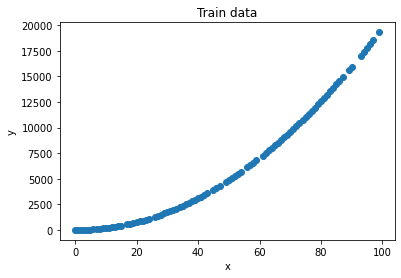

In [4]:
plt.scatter(X_train, y_train)
plt.title("Train data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

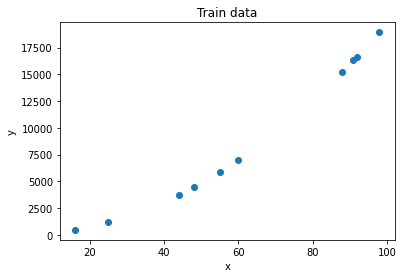

In [5]:
plt.scatter(X_test, y_test)
plt.title("Train data")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [81]:
GRAMMAR_FILE = 'exp-grammar.bnf'
BNF_GRAMMAR = Grammar(path.join("grammars", GRAMMAR_FILE))

In [94]:
def write_stat(value, file_name):
    with open(file_name, "w") as write_file:
        write_file.write(str(value))


def read_stat(file_name):
    with open(file_name, "r") as write_file:
        cnt = int(write_file.read())
    return cnt

In [96]:
### cold-start
with open("statistics.txt", "w") as write_file:
    write_file.write(str(0))

In [97]:
def fitness_eval(individual, points):
    #points = [X, Y]
    x = points[0]
    y = points[1]
    
    if individual.invalid == True:
        return np.NaN,
    try:
        # pred = eval(individual.phenotype)
        pred = eval(parse_(individual.phenotype))
    # except (FloatingPointError, ZeroDivisionError, OverflowError,
    #         MemoryError, ValueError):
    except Exception as e:
        cnt = read_stat("statistics.txt") + 1
        write_stat(cnt, "statistics.txt")
        # write_stat(e, "statistics.txt")
        return np.NaN,
    assert np.isrealobj(pred)
    
    try:
        fitness = np.mean(np.absolute(y - pred))
    # except (FloatingPointError, ZeroDivisionError, OverflowError,
    #         MemoryError, ValueError):
    except Exception as e:
        # cnt = read_stat("statistics.txt") + 1
        write_stat(cnt, "statistics.txt")
        # write_stat(e, "statistics.txt")
        fitness = np.NaN
        
    if fitness == float("inf"):
        return np.NaN,
    
    return fitness,

In [98]:
toolbox = base.Toolbox()

# define a single objective, minimising fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create('Individual', ge.Individual, fitness=creator.FitnessMin)

toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 

toolbox.register("evaluate", fitness_eval)#, points=[X_train, Y_train])

# Tournament selection:
toolbox.register("select", ge.selTournament, tournsize=3)

# Single-point crossover:
toolbox.register("mate", ge.crossover_onepoint)

# Flip-int mutation:
toolbox.register("mutate", ge.mutation_int_flip_per_codon)


In [99]:
POPULATION_SIZE = 100
MAX_GENERATIONS = 50
P_CROSSOVER = 0.8
P_MUTATION = 0.01
ELITE_SIZE = round(0.01*POPULATION_SIZE)

HALL_OF_FAME_SIZE = 1
MAX_INIT_TREE_DEPTH = 10
MIN_INIT_TREE_DEPTH = 1
MAX_TREE_DEPTH = 15
MAX_WRAPS = 0
CODON_SIZE = 255

In [100]:
# create initial population (generation 0):
population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                        bnf_grammar=BNF_GRAMMAR, 
                                        min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                        max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                        max_tree_depth=MAX_TREE_DEPTH, 
                                        max_wraps=MAX_WRAPS,
                                        codon_size=CODON_SIZE
                                        )

In [101]:
# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

import math 
# prepare the statistics object:
#stats = tools.Statistics(key=lambda ind: ind.fitness.values if math.isnan(ind.fitness.values[0]) else None)#ind.fitness.values != np.inf else None)
#stats = tools.Statistics(key=lambda ind: ind.fitness.values[0] if not math.isnan(ind.fitness.values[0]) else np.NaN)#ind.fitness.values != np.inf else None)
stats = tools.Statistics(key=lambda ind: ind.fitness.values)# if not ind.invalid else (np.NaN,))#ind.fitness.values != np.inf else None)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

In [102]:
# perform the Grammatical Evolution flow:
population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                          bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE, 
                                          max_tree_depth=MAX_TREE_DEPTH, max_wraps=MAX_WRAPS,
                                          points_train=[X_train, y_train], 
                                          points_test=[X_test, y_test], 
                                          stats=stats, halloffame=hof, verbose=True)

gen	invalid	avg       	std        	min    	max    	fitness_test	best_ind_length	avg_length	max_length	selection_time	generation_time
0  	0      	2.2027e+09	1.60712e+10	4741.78	1.6e+11	7608.02     	234            	81.75     	354       	0             	0.118422       
1  	42     	13117.3   	38817.9    	4741.78	292522 	7608.02     	234            	35.66     	243       	0.000591278   	0.109456       
2  	13     	7639.92   	10113.7    	4741.78	67064.4	7608.02     	234            	32.89     	234       	0.0005548     	0.0822792      
3  	9      	7271.57   	9259.33    	4741.78	57895.6	7608.02     	234            	21.05     	234       	0.000541449   	0.0595007      
4  	8      	7165.98   	9317.41    	4741.78	57895.6	7608.02     	234            	25.06     	234       	0.00067234    	0.0780075      
5  	14     	5379.82   	524.893    	4741.78	8815.6 	7608.02     	234            	23.1      	234       	0.000522614   	0.064769       
6  	14     	7712.08   	11089.7    	4741.78	57935.6	7608.02     	234  

In [103]:
import textwrap
best = parse_(hof.items[0].phenotype)
print("Best individual: \n","\n".join(textwrap.wrap(best,80)))
print("\nTraining Fitness: ", hof.items[0].fitness.values[0])
print("Depth: ", hof.items[0].depth)
print("Length of the genome: ", len(hof.items[0].genome))
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')

Best individual: 
 x[0]/(x[0]+1e-08)*x[0]*x[0]/(x[0]+1e-08)-x[0]+x[0]/(x[0]+1e-08)-x[0]/(x[0]+1e-08
)/(x[0]+1e-08)*x[0]-4/(x[0]+1e-08)*x[0]+x[0]*1-7/(x[0]+1e-08)*x[0]-x[0]+x[0]/(x[
0]+1e-08)*x[0]+3-x[0]*x[0]/(x[0]+1e-08)+x[0]*x[0]-x[0]/(x[0]+1e-08)/(x[0]+1e-08)
/(x[0]+1e-08)*x[0]*x[0]*x[0]+x[0]/(x[0]+1e-08)-x[0]-x[0]*x[0]+x[0]*x[0]*x[0]/(x[
0]+1e-08)-x[0]+x[0]/(x[0]+1e-08)-9-x[0]/(x[0]+1e-08)-x[0]/(x[0]+1e-08)/(x[0]+1e-
08)-x[0]/(x[0]+1e-08)+x[0]*x[0]*x[0]/(x[0]+1e-08)+x[0]*x[0]/(x[0]+1e-08)+x[0]*x[
0]-x[0]-x[0]/(x[0]+1e-08)+x[0]/(x[0]+1e-08)+x[0]/(x[0]+1e-08)*x[0]/(x[0]+1e-08)-
x[0]

Training Fitness:  4741.777777777777
Depth:  9
Length of the genome:  234
Used portion of the genome: 0.67


In [104]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")
fitness_test = logbook.select("fitness_test")
best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")
max_length = logbook.select("max_length")
selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")

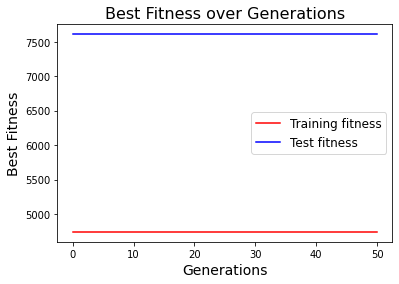

In [105]:
plt.plot(gen, min_fitness_values, color='red', label="Training fitness")
plt.plot(gen, fitness_test, color='blue', label="Test fitness")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness over Generations', fontsize=16)
plt.show()

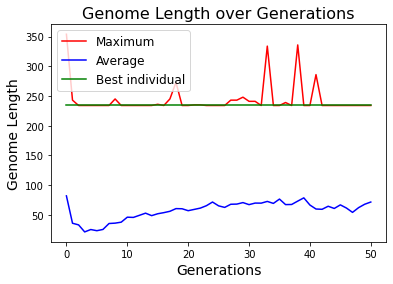

In [106]:
plt.plot(gen, max_length, color='red', label="Maximum")
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()